<a href="https://colab.research.google.com/github/yongtangli/Neural_Manifolds/blob/main/Manifold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [17]:
import torch
import numpy as np
from pathlib import Path
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths to brain tumor pt files
brain_tumor_path = Path('__pycache__/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor')
healthy_path = Path('__pycache__/Brain Tumor Data Set/Brain Tumor Data Set/Healthy')
import random
from pathlib import Path

brain_tumor_path = Path('__pycache__/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor')
healthy_path = Path('__pycache__/Brain Tumor Data Set/Brain Tumor Data Set/Healthy')

# Collect file paths (adjust suffixes if needed)
brain_files = list(brain_tumor_path.glob('*.pt'))
healthy_files = list(healthy_path.glob('*.pt'))



# Collect all pt files
pt_files = sorted(list(brain_tumor_path.glob('*.pt'))) + sorted(list(healthy_path.glob('*.pt')))
print(f"Found {len(pt_files)} pt files")

# Create mapping: each pt file is a node
node_mapping = {i: str(pt_file) for i, pt_file in enumerate(pt_files)}
file_to_node = {str(pt_file): i for i, pt_file in enumerate(pt_files)}

print(f"\nFirst 5 nodes:")
for i in range(min(5, len(node_mapping))):
    print(f"  Node {i}: {Path(node_mapping[i]).name}")

Using device: cuda
Found 4432 pt files

First 5 nodes:
  Node 0: Cancer (1).pt
  Node 1: Cancer (10).pt
  Node 2: Cancer (100).pt
  Node 3: Cancer (1000).pt
  Node 4: Cancer (1001).pt


In [18]:
def wasserstein_distance_images(tensor1, tensor2, epsilon=0.01, max_iter=500, tol=1e-9, max_points=500):
    """
    Entropic-regularized Wasserstein distance (Sinkhorn) between two images.

    Args:
        tensor1, tensor2: (num_pixels, 3) arrays ([x, y, grayscale]) as torch tensors
        epsilon: entropic regularization strength (larger -> faster, more blurred transport)
        max_iter: maximum Sinkhorn iterations
        tol: stopping tolerance on scaling vectors
        max_points: downsample limit for speed/memory

    Returns:
        Sinkhorn transport cost (float)
    """
    if tensor1 is None or tensor2 is None:
        return float('inf')

    if len(tensor1) == 0 or len(tensor2) == 0:
        return float('inf')

    # Convert to numpy
    x1 = tensor1.numpy().astype(np.float64)
    x2 = tensor2.numpy().astype(np.float64)

    # Normalize each coordinate to [0,1] using combined min/max
    x1_norm = np.zeros_like(x1)
    x2_norm = np.zeros_like(x2)
    for dim in range(x1.shape[1]):
        combined_min = min(x1[:, dim].min(), x2[:, dim].min())
        combined_max = max(x1[:, dim].max(), x2[:, dim].max())
        if combined_max > combined_min:
            x1_norm[:, dim] = (x1[:, dim] - combined_min) / (combined_max - combined_min)
            x2_norm[:, dim] = (x2[:, dim] - combined_min) / (combined_max - combined_min)
        else:
            x1_norm[:, dim] = 0.5
            x2_norm[:, dim] = 0.5

    # Downsample for performance if needed
    if len(x1_norm) > max_points:
        idx1 = np.random.choice(len(x1_norm), max_points, replace=False)
        x1_norm = x1_norm[idx1]
    if len(x2_norm) > max_points:
        idx2 = np.random.choice(len(x2_norm), max_points, replace=False)
        x2_norm = x2_norm[idx2]

    # Uniform weights
    n = x1_norm.shape[0]
    m = x2_norm.shape[0]
    a = np.ones(n) / n
    b = np.ones(m) / m

    # Cost matrix
    C = cdist(x1_norm, x2_norm, metric='euclidean')

    # Kernel matrix
    K = np.exp(-C / epsilon)
    K[K < 1e-300] = 1e-300

    # Initialize scaling vectors
    u = np.ones(n)
    v = np.ones(m)

    # Sinkhorn iterations (stabilized by simple scaling)
    for _ in range(max_iter):
        u_prev = u
        u = a / (K @ v)
        v = b / (K.T @ u)
        if np.linalg.norm(u - u_prev, 1) < tol:
            break

    # Transport plan and cost
    T = (u[:, None] * K) * v[None, :]
    cost = np.sum(T * C)
    return float(cost)

print("Sinkhorn-based Wasserstein distance function defined")

Sinkhorn-based Wasserstein distance function defined


In [19]:
# Load all pt files and compute pairwise Wasserstein distances
import random
sample_size = 100  # Adjust sample size as needed
sample_size = min(sample_size, len(pt_files))
half = sample_size // 2

# Safety check
if len(brain_files) < half or len(healthy_files) < half:
    raise ValueError("Not enough images in one of the classes")

# Randomly sample
brain_sample = random.sample(brain_files, half)
healthy_sample = random.sample(healthy_files, half)

# Combine
sample_paths = brain_sample + healthy_sample

# Optional: shuffle so labels are mixed
random.shuffle(sample_paths)
sample_indices = random.sample(range(len(sample_paths)), sample_size)
# Use all available files


print(f"Computing pairwise Wasserstein distances for {sample_size} images...\n")
print("WARNING: This computes O(n^2) pairwise distances; it may be very slow and memory intensive for large n.")

# Initialize distance matrix
distance_matrix = np.zeros((sample_size, sample_size))

# Load tensors
tensors = {}
for i, pt_file in enumerate(sample_paths):
    try:
        tensors[i] = torch.load(pt_file)
    except Exception as e:
        print(f"Error loading {pt_file.name}: {e}")
        tensors[i] = None

# Compute pairwise distances
for i in tqdm(range(sample_size), desc="Computing distances"):
    for j in range(i + 1, sample_size):
            ti = tensors[i]
            tj = tensors[j]
            dist = wasserstein_distance_images(ti, tj)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

print(f"\nDistance matrix computed!")
print(f"Shape: {distance_matrix.shape}")
# Use masked arrays to avoid zeros and inf when reporting
valid = (distance_matrix != 0) & (distance_matrix != np.inf)
if np.any(valid):
    print(f"Min distance: {distance_matrix[valid].min():.4f}")
    print(f"Max distance: {distance_matrix[valid].max():.4f}")
    print(f"Mean distance: {distance_matrix[valid].mean():.4f}")
else:
    print("No finite non-zero distances computed.")

/tmp/ipykernel_885250/3901968182.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors[i] = torch.load(pt_file)


Computing pairwise Wasserstein distances for 100 images...



Computing distances: 100%|██████████| 100/100 [04:34<00:00,  2.75s/it]


Distance matrix computed!
Shape: (100, 100)
Min distance: 0.0698
Max distance: 0.4690
Mean distance: 0.2094


In [21]:
# Heat kernel graph construction
G = nx.Graph()

# Add nodes (same as before)
for i, pt_file in enumerate(sample_paths):
    image_name = pt_file.name
    is_tumor = (pt_file.parent.name == 'Brain Tumor')
    G.add_node(i, name=image_name, is_tumor=is_tumor)


# Kernel scale (sigma)
valid_distances = distance_matrix[(distance_matrix > 0) & (distance_matrix < np.inf)]
sigma = np.median(valid_distances)

print(f"Heat kernel sigma: {sigma:.4f}")

# Add weighted edges
for i in range(sample_size):
    for j in range(i + 1, sample_size):
        d = distance_matrix[i, j]
        if d > 0 and np.isfinite(d):
            w = np.exp(-(d ** 2) / (sigma ** 2))
            if w > 1e-6:  # numerical sparsification
                G.add_edge(i, j, weight=w)


print(f"Graph created:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
tumor_count = sum(G.nodes[i]['is_tumor'] for i in G.nodes())
healthy_count = G.number_of_nodes() - tumor_count

print("Tumor nodes:", tumor_count)
print("Healthy nodes:", healthy_count)


# Show some edge examples
if G.number_of_edges() > 0:
    print(f"\nFirst 10 edges with Wasserstein distances:")
    for idx, (u, v, data) in enumerate(G.edges(data=True)):
        if idx >= 10:
            break
        name_u = G.nodes[u]['name']
        name_v = G.nodes[v]['name']
        weight = data['weight']
        print(f"  {name_u} <-> {name_v}: {weight:.4f}")

Heat kernel sigma: 0.1954
Graph created:
  Nodes: 100
  Edges: 4950
Tumor nodes: 50
Healthy nodes: 50

First 10 edges with Wasserstein distances:
  Not Cancer  (1667).pt <-> Cancer (275).pt: 0.2317
  Not Cancer  (1667).pt <-> Not Cancer  (577).pt: 0.4053
  Not Cancer  (1667).pt <-> Not Cancer  (1893).pt: 0.2945
  Not Cancer  (1667).pt <-> Not Cancer  (1961).pt: 0.0379
  Not Cancer  (1667).pt <-> Cancer (892).pt: 0.1743
  Not Cancer  (1667).pt <-> Not Cancer  (405).pt: 0.3197
  Not Cancer  (1667).pt <-> Not Cancer  (1062).pt: 0.5352
  Not Cancer  (1667).pt <-> Not Cancer  (310).pt: 0.4791
  Not Cancer  (1667).pt <-> Not Cancer  (90).pt: 0.3763
  Not Cancer  (1667).pt <-> Not Cancer  (51).pt: 0.3097


In [22]:
# Compute degree matrix, adjacency matrix, and Laplacian
print("Computing graph matrices...\n")

# Weighted adjacency matrix
A = nx.to_numpy_array(G, weight='weight')
A = torch.tensor(A, dtype=torch.float32)

# Degree matrix
degree = A.sum(dim=1)
D_inv_sqrt = torch.diag(1.0 / torch.sqrt(degree + 1e-8))

# Normalized Laplacian
L = torch.eye(sample_size) - D_inv_sqrt @ A @ D_inv_sqrt
D = torch.diag(degree)


print(f"Degree Matrix (D) shape: {D.shape}")
print(f"Adjacency Matrix (A) shape: {A.shape}")
print(f"Laplacian Matrix (L) shape: {L.shape}")

print(f"\nDegree Matrix (first 5x5):")
print(D[:5, :5])

print(f"\nAdjacency Matrix (first 5x5):")
print(A[:5, :5])

print(f"\nLaplacian Matrix (first 5x5):")
print(L[:5, :5])

# Compute eigenvalues and eigenvectors of Laplacian
eigenvalues, eigenvectors = torch.linalg.eigh(L)
print(f"\nLaplacian eigenvalues (first 10):")
print(eigenvalues[:10])

print(f"Laplacian eigenvectors shape: {eigenvectors.shape}")

Computing graph matrices...

Degree Matrix (D) shape: torch.Size([100, 100])
Adjacency Matrix (A) shape: torch.Size([100, 100])
Laplacian Matrix (L) shape: torch.Size([100, 100])

Degree Matrix (first 5x5):
tensor([[31.3032,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 43.5111,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 41.6982,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 33.9132,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  9.5550]])

Adjacency Matrix (first 5x5):
tensor([[0.0000, 0.2317, 0.4053, 0.2945, 0.0379],
        [0.2317, 0.0000, 0.6042, 0.2472, 0.0096],
        [0.4053, 0.6042, 0.0000, 0.3843, 0.0203],
        [0.2945, 0.2472, 0.3843, 0.0000, 0.1494],
        [0.0379, 0.0096, 0.0203, 0.1494, 0.0000]])

Laplacian Matrix (first 5x5):
tensor([[ 1.0000e+00, -6.2786e-03, -1.1217e-02, -9.0393e-03, -2.1896e-03],
        [-6.2786e-03,  1.0000e+00, -1.4186e-02, -6.4355e-03, -4.7304e-04],
        [-1.1217e-02, -1.4186e-02,  1.0000e+00, -1.022

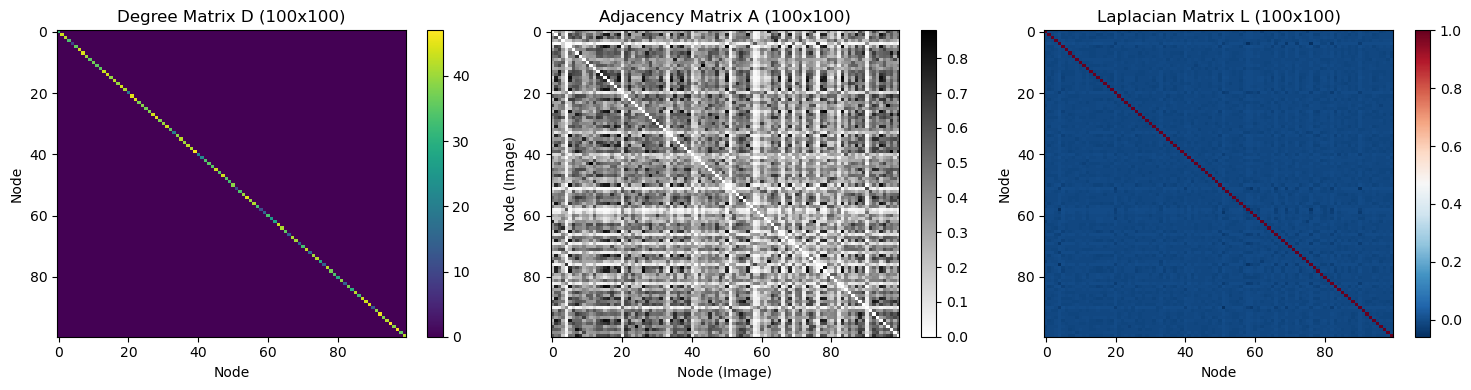

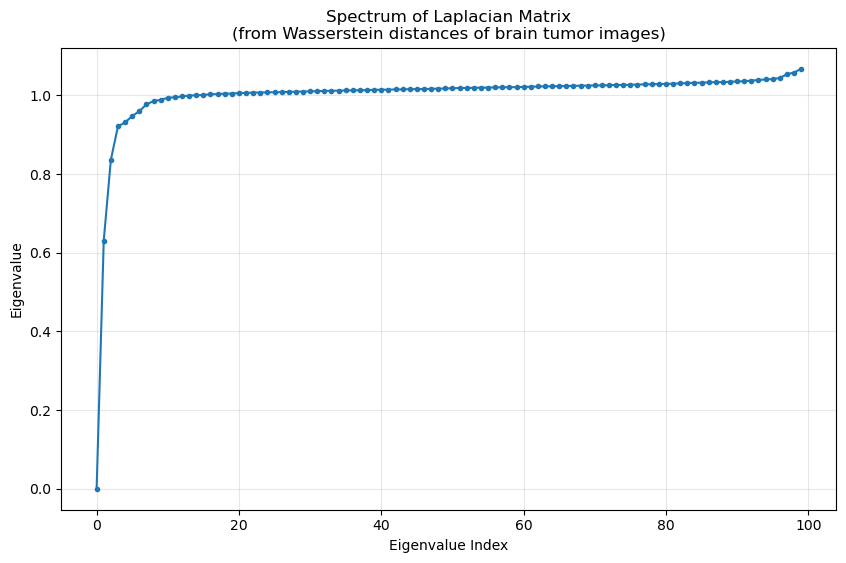


Laplacian Matrix Statistics:
  Min eigenvalue: -0.000000
  Max eigenvalue: 1.067634
  Sum of eigenvalues: 100.000015
  Number of zero eigenvalues (tolerance=1e-6): 1


In [23]:
# Visualize the matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Degree Matrix
im0 = axes[0].imshow(D.numpy(), cmap='viridis', aspect='auto')
axes[0].set_title(f'Degree Matrix D ({sample_size}x{sample_size})')
axes[0].set_xlabel('Node')
axes[0].set_ylabel('Node')
plt.colorbar(im0, ax=axes[0])

# Adjacency Matrix (Wasserstein distance based)
im1 = axes[1].imshow(A.numpy(), cmap='binary', aspect='auto')
axes[1].set_title(f'Adjacency Matrix A ({sample_size}x{sample_size})')
axes[1].set_xlabel('Node (Image)')
axes[1].set_ylabel('Node (Image)')
plt.colorbar(im1, ax=axes[1])

# Laplacian Matrix
im2 = axes[2].imshow(L.numpy(), cmap='RdBu_r', aspect='auto')
axes[2].set_title(f'Laplacian Matrix L ({sample_size}x{sample_size})')
axes[2].set_xlabel('Node')
axes[2].set_ylabel('Node')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# Plot eigenvalue spectrum
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(eigenvalues.numpy(), 'o-', markersize=3)
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Spectrum of Laplacian Matrix\n(from Wasserstein distances of brain tumor images)')
ax.grid(True, alpha=0.3)
plt.show()

# Statistics
print(f"\nLaplacian Matrix Statistics:")
print(f"  Min eigenvalue: {eigenvalues.min():.6f}")
print(f"  Max eigenvalue: {eigenvalues.max():.6f}")
print(f"  Sum of eigenvalues: {eigenvalues.sum():.6f}")
print(f"  Number of zero eigenvalues (tolerance=1e-6): {(eigenvalues.abs() < 1e-6).sum().item()}")

In [24]:
# Perform spectral embedding to reduce to 3D
print("Performing spectral embedding (graph -> 3D)...\n")

# Use eigenvectors corresponding to smallest non-zero eigenvalues
n_components = min(3, sample_size - 1)
embedding_3d = eigenvectors[:, 1:n_components+1]  # Skip first eigenvalue (usually ~0)

print(f"Original node dimension: graph with {sample_size} images")
print(f"Embedded dimension: {n_components} (using Laplacian eigenvectors)")
print(f"Embedding shape: {embedding_3d.shape}")

# Normalize embedding for better visualization
embedding_3d_normalized = embedding_3d / (torch.norm(embedding_3d, dim=0, keepdim=True) + 1e-8)

print(f"\nEmbedding statistics:")
print(f"  Min: {embedding_3d.min():.4f}, Max: {embedding_3d.max():.4f}")
print(f"  Mean: {embedding_3d.mean():.4f}, Std: {embedding_3d.std():.4f}")

print(f"\nSmallest eigenvalues (first 5):")
print(eigenvalues[:5])

Performing spectral embedding (graph -> 3D)...

Original node dimension: graph with 100 images
Embedded dimension: 3 (using Laplacian eigenvectors)
Embedding shape: torch.Size([100, 3])

Embedding statistics:
  Min: -0.2575, Max: 0.2126
  Mean: -0.0027, Std: 0.1001

Smallest eigenvalues (first 5):
tensor([-5.1338e-08,  6.3086e-01,  8.3615e-01,  9.2123e-01,  9.3107e-01])


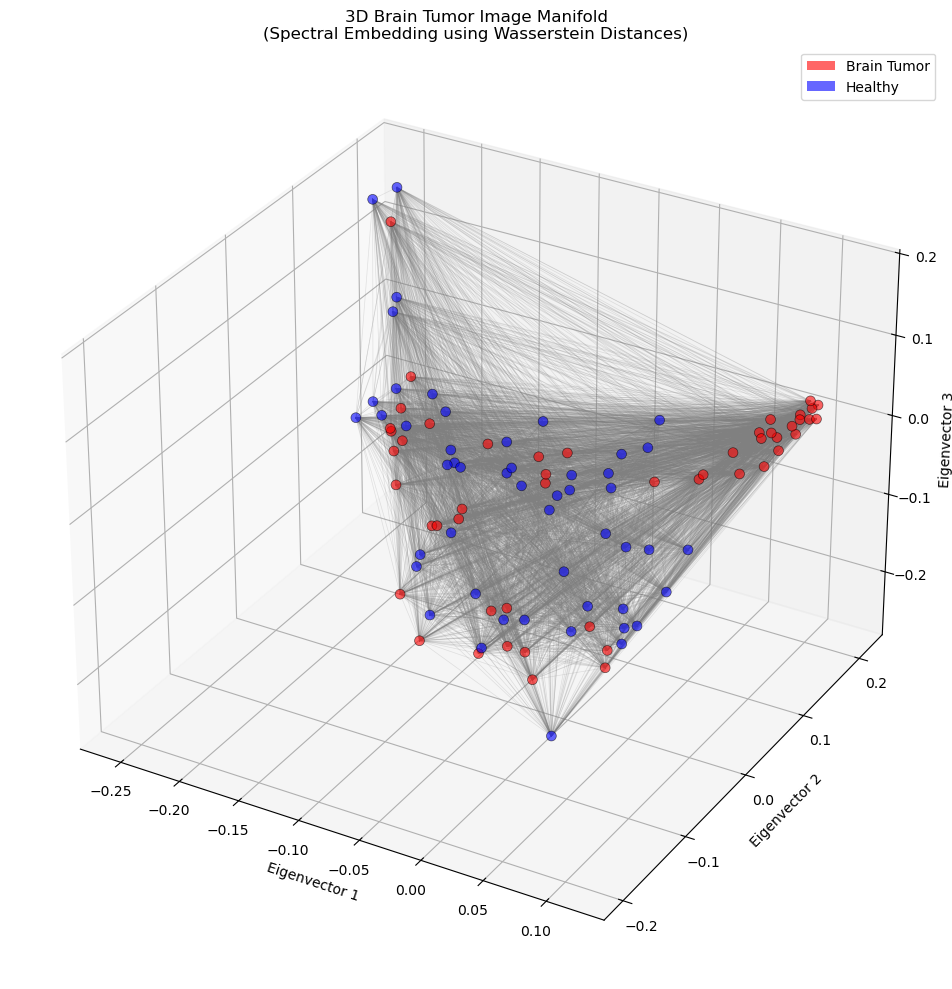

3D manifold visualization created!
  Total nodes: 100 (images)
  Total edges: 4950
  Red points: Brain Tumor images
  Blue points: Healthy images


In [25]:
# Create 3D scatter plot of the manifold
if embedding_3d.shape[1] >= 3:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract 3D coordinates
    x = embedding_3d[:, 0].numpy()
    y = embedding_3d[:, 1].numpy()
    z = embedding_3d[:, 2].numpy()
    
    # Color by whether it's a tumor or healthy
    colors = ['red' if G.nodes[i]['is_tumor'] else 'blue' for i in range(sample_size)]
    
    # Plot nodes
    scatter = ax.scatter(x, y, z, c=colors, s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
    
    # Plot edges
    edges = G.edges()
    for u, v in edges:
        ax.plot([x[u], x[v]], [y[u], y[v]], [z[u], z[v]], 'gray', alpha=0.2, linewidth=0.5)
    
    ax.set_xlabel('Eigenvector 1')
    ax.set_ylabel('Eigenvector 2')
    ax.set_zlabel('Eigenvector 3')
    ax.set_title('3D Brain Tumor Image Manifold\n(Spectral Embedding using Wasserstein Distances)')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.6, label='Brain Tumor'),
                      Patch(facecolor='blue', alpha=0.6, label='Healthy')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"3D manifold visualization created!")
    print(f"  Total nodes: {len(x)} (images)")
    print(f"  Total edges: {G.number_of_edges()}")
    print(f"  Red points: Brain Tumor images")
    print(f"  Blue points: Healthy images")
else:
    print(f"Warning: Only {embedding_3d.shape[1]} dimensions available for 3D plot")

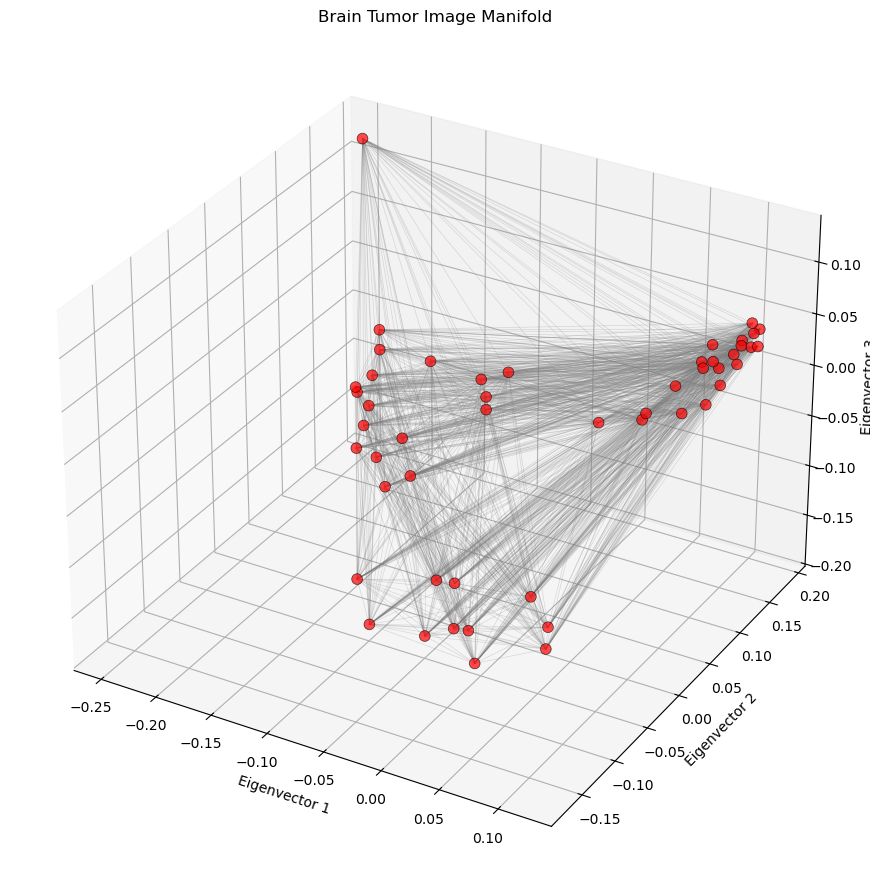

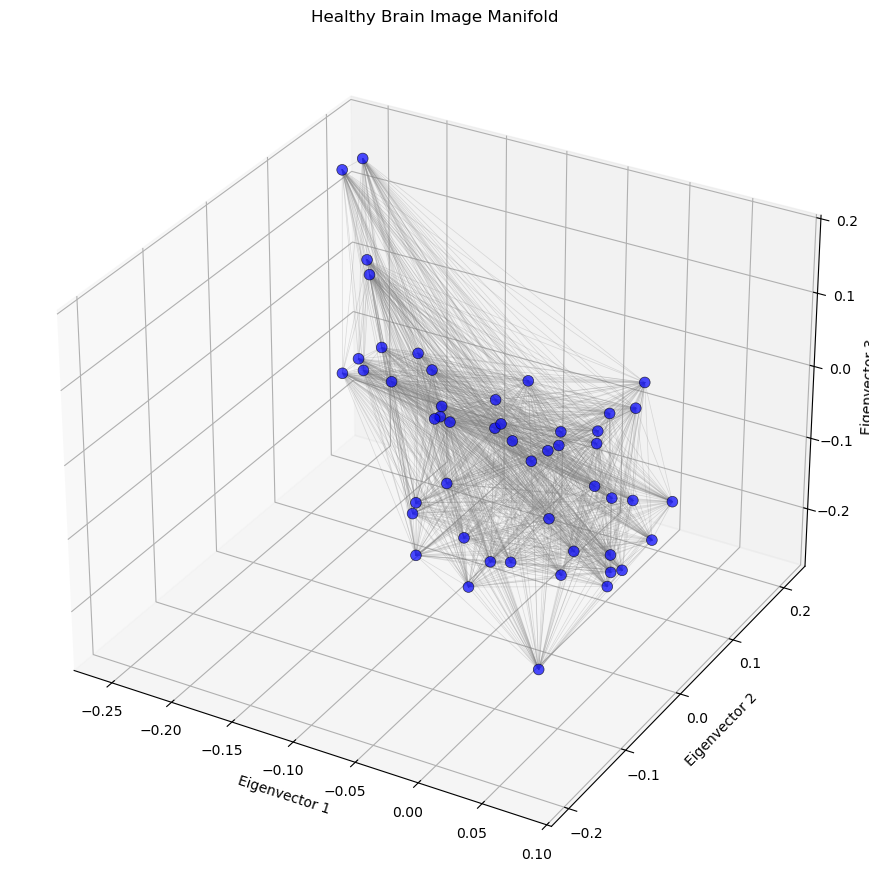

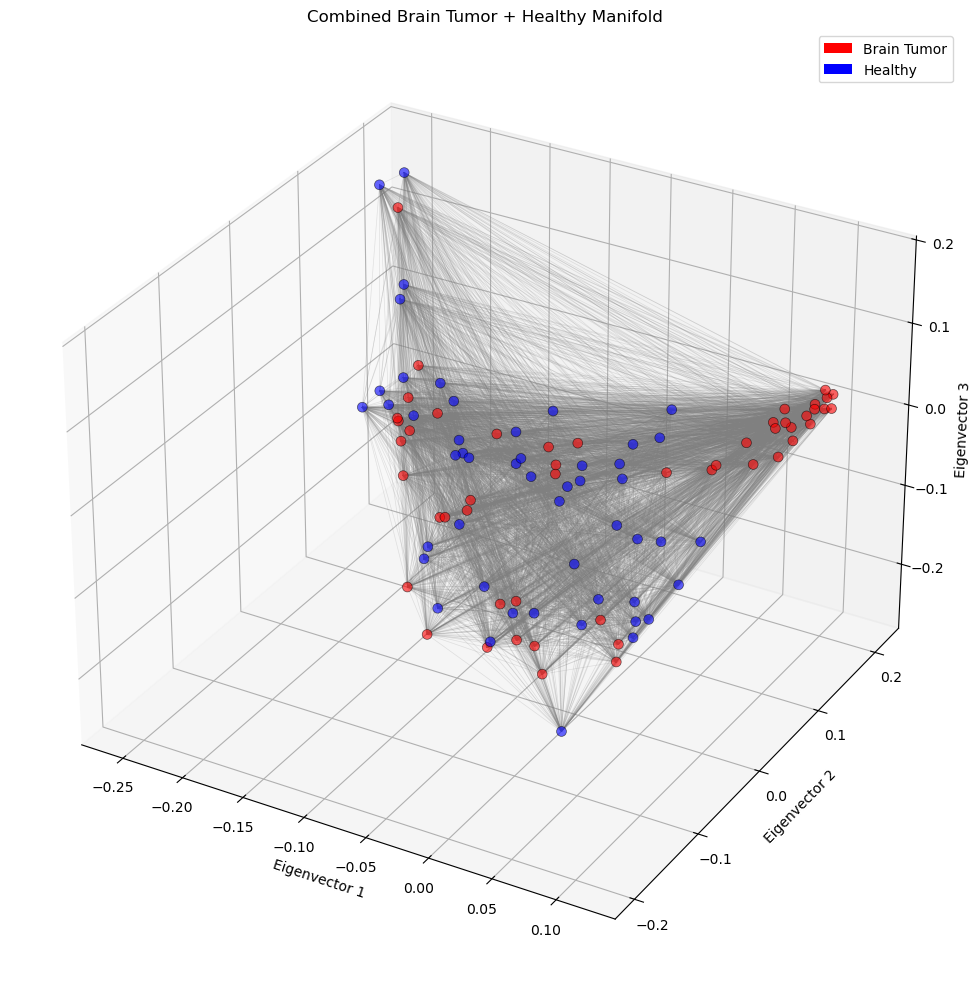

In [26]:
import numpy as np

# Boolean mask
is_tumor = np.array([G.nodes[i]['is_tumor'] for i in range(sample_size)])
tumor_idx = np.where(is_tumor)[0]
healthy_idx = np.where(~is_tumor)[0]

def plot_3d_manifold(indices, title, color):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    x = embedding_3d[indices, 0].numpy()
    y = embedding_3d[indices, 1].numpy()
    z = embedding_3d[indices, 2].numpy()

    ax.scatter(x, y, z, c=color, s=60, alpha=0.7,
               edgecolors='k', linewidth=0.5)

    # Plot only edges fully inside the subset
    for u, v in G.edges():
        if u in indices and v in indices:
            iu = np.where(indices == u)[0][0]
            iv = np.where(indices == v)[0][0]
            ax.plot([x[iu], x[iv]],
                    [y[iu], y[iv]],
                    [z[iu], z[iv]],
                    color='gray', alpha=0.25, linewidth=0.5)

    ax.set_xlabel('Eigenvector 1')
    ax.set_ylabel('Eigenvector 2')
    ax.set_zlabel('Eigenvector 3')
    ax.set_title(title)

    plt.tight_layout()
    plt.show()
plot_3d_manifold(
    tumor_idx,
    title='Brain Tumor Image Manifold',
    color='red'
)
plot_3d_manifold(
    healthy_idx,
    title='Healthy Brain Image Manifold',
    color='blue'
)
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

x = embedding_3d[:, 0].numpy()
y = embedding_3d[:, 1].numpy()
z = embedding_3d[:, 2].numpy()

colors = ['red' if G.nodes[i]['is_tumor'] else 'blue' for i in range(sample_size)]

ax.scatter(x, y, z, c=colors, s=50, alpha=0.6,
           edgecolors='k', linewidth=0.5)

for u, v in G.edges():
    ax.plot([x[u], x[v]], [y[u], y[v]], [z[u], z[v]],
            color='gray', alpha=0.2, linewidth=0.5)

ax.set_xlabel('Eigenvector 1')
ax.set_ylabel('Eigenvector 2')
ax.set_zlabel('Eigenvector 3')
ax.set_title('Combined Brain Tumor + Healthy Manifold')

from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(facecolor='red', label='Brain Tumor'),
    Patch(facecolor='blue', label='Healthy')
])

plt.tight_layout()
plt.show()

